# Deep hedging in illiquid financial markets

In this Jupyter notebook, we study the problem of hedging a European Call option in an illiquid financial market under a parameter-dependent change of measure by implementing a parameter-dependent density process. We consider a quadratic loss function and an illiquid version of the Bachelier model. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K

import matplotlib.pyplot as plt

import copy
import random

import scipy.stats as scipy
from scipy.stats import norm

In [2]:
N      = 25      # time disrectization
T      = 1       # maturity
strike = 1       # strike for European option
sigma  = 0.3     # volatility
mu     = 0.1     # drift

In [13]:
kappa1  = 0.5

In [4]:
def Bachelier(S0, strike, T, sigma):
    return (S0-strike)*scipy.norm.cdf((S0-strike)/(S0*sigma*np.sqrt(T)))+S0*sigma*np.sqrt(T)*scipy.norm.pdf((S0-strike)/(S0*sigma*np.sqrt(T)))

priceBachelier=Bachelier(1,strike,T,sigma)
print(priceBachelier)

0.1196826841204298


In [5]:
# Definition of neural networks

m = 1 # dimension of price
d = 2 # number of layers in strategy
n = 5 # nodes in the first (d-1) layers

layers = []
for j in range(N):
    for i in range(d): 
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [6]:
# building up the loss function
kappa = 0

price       = Input(shape=(m,))
hedge       = Input(shape=(m,)) 
premium     = Input(shape=(m,))
sum1_helper = Input(shape=(m,))
sum2_helper = Input(shape=(m,))

inputs  = [price]+[hedge]+[premium]+[sum1_helper]+[sum2_helper]

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),
                bias_initializer=initializers.RandomNormal(0,1))(premium)

for j in range(N):
    strategy = price
    for k in range(d):
        strategy = layers[k+(j)*d](strategy) 
    
    # increments of Brownian motion as training data
    incr   = Input(shape = (m,)) 
    inputs = inputs + [incr]
    
    #increment of price process
    priceincr_drift = Lambda(lambda x : (mu+kappa*x)*T/N)(strategy)
    price           = Add()([price, priceincr_drift])
    priceincr_vola  = Lambda(lambda x : sigma*np.sqrt(T)/np.sqrt(N)*x)(incr)
    price           = Add()([price, priceincr_vola])
    
    #increment of wealth process
    wealthincr_drift = Lambda(lambda x : (mu*x+0.5*kappa*x**2)*T/N)(strategy)
    hedge            = Add()([hedge,wealthincr_drift]) 
    wealthincr_vola  = Lambda(lambda x : sigma*np.sqrt(T)/np.sqrt(N)*x)(incr)
    wealthincr_vola  = Multiply()([wealthincr_vola, strategy])
    hedge            = Add()([hedge,wealthincr_vola]) 
    
    #building up density
    helper1     = Lambda(lambda x : (-0.5)*(mu+0.5*kappa*x)/sigma*np.sqrt(T)/np.sqrt(N))(strategy) # 0.5 = square root
    helper1     = Multiply()([helper1,incr])
    sum1_helper = Add()([sum1_helper,helper1]) 
    helper2     = Lambda(lambda x : (-0.25)*K.square(mu+0.5*kappa*x)/K.square(sigma)*T/N)(strategy)# 0.25 = square root*1/2
    sum2_helper = Add()([sum2_helper,helper2])
    
summe   = Add()([sum1_helper,sum2_helper])
density = Lambda(lambda x : K.exp(x))(summe)
payoff  = Lambda(lambda x : K.relu(x-strike))(price) 
outputs = Subtract()([payoff,hedge]) 
outputs = Subtract()([outputs,premium])
outputs = Multiply()([outputs,density]) 

In [7]:
learnrate = 0.01
adam = optimizers.Adam(learning_rate=learnrate)
stopping_rule = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10, restore_best_weights=True)

In [8]:
bachelier_liquid = Model(inputs=inputs, outputs=outputs)
bachelier_liquid.compile(optimizer=adam, loss='mean_squared_error')

In [9]:
Ktrain = 2*10**5 


y     = np.random.uniform(0,2,Ktrain)
price = Bachelier(y,strike,T,sigma)


xtrain = ([y]                    + 
          [np.zeros((Ktrain,m))] + 
          [price]                +
          [np.zeros((Ktrain,m))] +
          [np.zeros((Ktrain,m))] +
          [np.random.normal(0,1,(Ktrain,m)) for i in range(N)])

ytrain = np.zeros((Ktrain,1+N)) 

In [10]:
history_liquid = bachelier_liquid.fit(x=xtrain, y=ytrain, epochs=150, verbose = 1, batch_size=1024, validation_split=0.2, callbacks=[stopping_rule])

Epoch 1/150
157/157 [==============================] - 22s 33ms/step - loss: 0.1168 - val_loss: 0.0026
Epoch 2/150
157/157 [==============================] - 2s 11ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/150
157/157 [==============================] - 2s 13ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/150
157/157 [==============================] - 4s 28ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/150
157/157 [==============================] - 4s 26ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/150
157/157 [==============================] - 4s 26ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/150
157/157 [==============================] - 3s 18ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/150
157/157 [==============================] - 3s 18ms/step - loss: 0.0011 - val_loss: 9.7774e-04
Epoch 9/150
157/157 [==============================] - 2s 15ms/step - loss: 9.7161e-04 - val_loss: 9.0219e-04
Epoch 10/150
157/157 [==============================] - 2s 14ms/step 

157/157 [==============================] - 2s 12ms/step - loss: 2.7578e-04 - val_loss: 2.6694e-04
Epoch 76/150
157/157 [==============================] - 3s 17ms/step - loss: 2.7066e-04 - val_loss: 2.7815e-04
Epoch 77/150
157/157 [==============================] - 2s 12ms/step - loss: 2.7914e-04 - val_loss: 2.6819e-04
Epoch 78/150
157/157 [==============================] - 2s 14ms/step - loss: 2.6907e-04 - val_loss: 2.7623e-04
Epoch 79/150
157/157 [==============================] - 2s 13ms/step - loss: 2.7003e-04 - val_loss: 2.7473e-04
Epoch 80/150
157/157 [==============================] - 2s 13ms/step - loss: 2.7524e-04 - val_loss: 2.6560e-04
Epoch 81/150
157/157 [==============================] - 2s 14ms/step - loss: 2.7215e-04 - val_loss: 2.7349e-04
Epoch 82/150
157/157 [==============================] - 2s 16ms/step - loss: 2.7131e-04 - val_loss: 2.8088e-04
Epoch 83/150
157/157 [==============================] - 2s 13ms/step - loss: 2.7225e-04 - val_loss: 2.7705e-04
Epoch 84/150
1

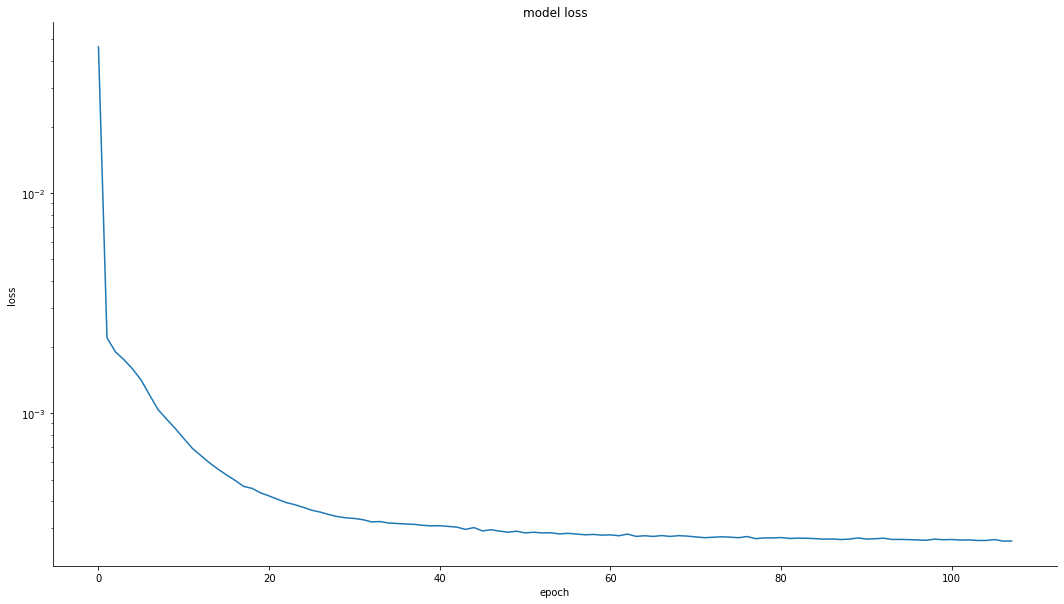

In [20]:
plt.figure(figsize=(18, 10))
plt.plot(history_liquid.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [11]:
# Definition of neural networks 

m = 1 # dimension of price
d = 2 # number of layers in strategy
n = 5 # nodes in the first (d-1) layers

layers_illiquid = []
for j in range(N): 
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers_illiquid = layers_illiquid + [layer]

In [14]:
# building up the loss function
kappa=kappa1

price       = Input(shape=(m,))
hedge       = Input(shape=(m,)) 
premium     = Input(shape=(m,))
sum1_helper = Input(shape=(m,))
sum2_helper = Input(shape=(m,))

inputs  = [price]+[hedge]+[premium]+[sum1_helper]+[sum2_helper]

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),
                bias_initializer=initializers.RandomNormal(0,1))(premium)

for j in range(N):
    strategy = price
    for k in range(d):
        strategy = layers_illiquid[k+(j)*d](strategy) 
    
    # increments of Brownian motion as training data
    incr   = Input(shape = (m,)) 
    inputs = inputs + [incr]
    
    #increment of price process
    priceincr_drift = Lambda(lambda x : (mu+kappa*x)*T/N)(strategy)
    price           = Add()([price, priceincr_drift])
    priceincr_vola  = Lambda(lambda x : sigma*np.sqrt(T)/np.sqrt(N)*x)(incr)
    price           = Add()([price, priceincr_vola])
    
    #increment of wealth process
    wealthincr_drift = Lambda(lambda x : (mu*x+0.5*kappa*x**2)*T/N)(strategy)
    hedge            = Add()([hedge,wealthincr_drift]) 
    wealthincr_vola  = Lambda(lambda x : sigma*np.sqrt(T)/np.sqrt(N)*x)(incr)
    wealthincr_vola  = Multiply()([wealthincr_vola, strategy])
    hedge            = Add()([hedge,wealthincr_vola]) 
    
    #building up density
    helper1     = Lambda(lambda x : (-0.5)*(mu+0.5*kappa*x)/sigma*np.sqrt(T)/np.sqrt(N))(strategy) # 0.5 = square root
    helper1     = Multiply()([helper1,incr])
    sum1_helper = Add()([sum1_helper,helper1]) 
    helper2     = Lambda(lambda x : (-0.25)*K.square(mu+0.5*kappa*x)/K.square(sigma)*T/N)(strategy)# 0.25 = square root*1/2
    sum2_helper = Add()([sum2_helper,helper2])
    
summe   = Add()([sum1_helper,sum2_helper])
density = Lambda(lambda x : K.exp(x))(summe)
payoff  = Lambda(lambda x : K.relu(x-strike))(price) 
outputs = Subtract()([payoff,hedge]) 
outputs = Subtract()([outputs,premium])
outputs = Multiply()([outputs,density]) 

In [15]:
bachelier_illiquid = Model(inputs=inputs, outputs=outputs)
bachelier_illiquid.compile(optimizer=adam, loss='mean_squared_error')
history_illiquid   = bachelier_illiquid.fit(x=xtrain, y=ytrain, epochs=150, verbose = 1, batch_size=1024, validation_split=0.2, callbacks=[stopping_rule])

Epoch 1/150
157/157 [==============================] - 22s 29ms/step - loss: 0.4542 - val_loss: 0.0096
Epoch 2/150
157/157 [==============================] - 2s 12ms/step - loss: 0.0072 - val_loss: 0.0043
Epoch 3/150
157/157 [==============================] - 2s 14ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 4/150
157/157 [==============================] - 2s 13ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 5/150
157/157 [==============================] - 2s 13ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/150
157/157 [==============================] - 2s 13ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/150
157/157 [==============================] - 2s 13ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/150
157/157 [==============================] - 2s 13ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/150
157/157 [==============================] - 2s 13ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/150
157/157 [==============================] - 2s 13ms/step - loss: 0.00

157/157 [==============================] - 2s 12ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 81/150
157/157 [==============================] - 2s 12ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 82/150
157/157 [==============================] - 2s 12ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 83/150
157/157 [==============================] - 2s 12ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 84/150
157/157 [==============================] - 2s 12ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 85/150
157/157 [==============================] - 2s 12ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 86/150
157/157 [==============================] - 2s 12ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 87/150
157/157 [==============================] - 2s 12ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 88/150
157/157 [==============================] - 2s 12ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 89/150
157/157 [==============================] - 2s 12ms/step - loss: 0.0018 - 

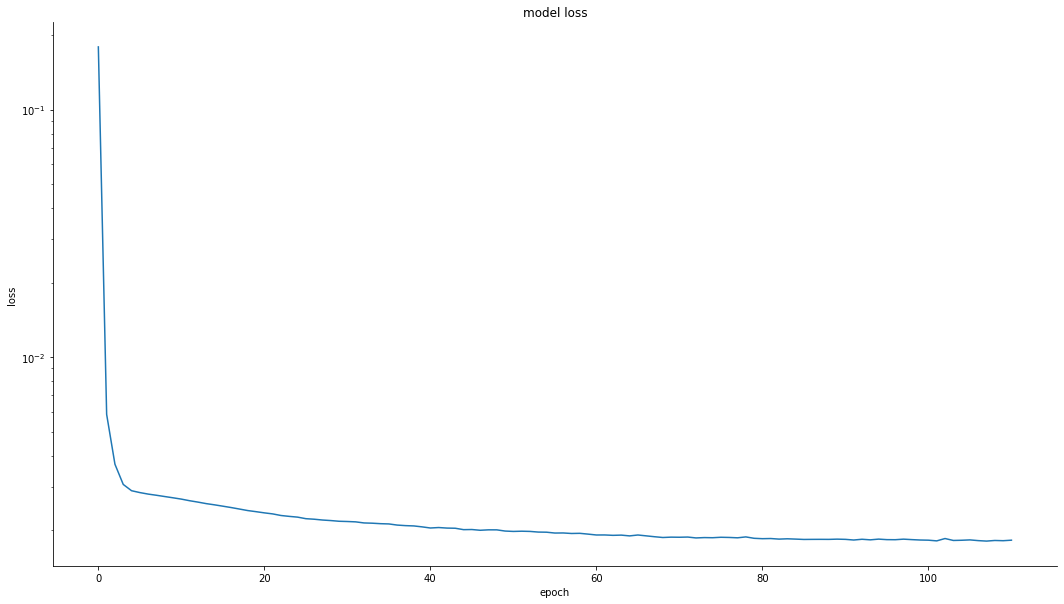

In [19]:
plt.figure(figsize=(18, 10))
plt.plot(history_illiquid.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()